# **Import Libraries**

In [358]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import math
from scipy.stats.mstats import winsorize
import plotly.express as px
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import r2_score, mean_absolute_error

# **Load Dataset**

In [359]:
df = pd.read_csv('Warehouse_and_Retail_Sales.csv')
df

,YEAR,MONTH,SUPPLIER,ITEM CODE,ITEM DESCRIPTION,ITEM TYPE,RETAIL SALES,RETAIL TRANSFERS,WAREHOUSE SALES
0,2020,1,REPUBLIC NATIONAL DISTRIBUTING CO,100009,BOOTLEG RED - 750ML,WINE,0.00,0.0,2.00
1,2020,1,PWSWN INC,100024,MOMENT DE PLAISIR - 750ML,WINE,0.00,1.0,4.00
2,2020,1,RELIABLE CHURCHILL LLLP,1001,S SMITH ORGANIC PEAR CIDER - 18.7OZ,BEER,0.00,0.0,1.00
3,2020,1,LANTERNA DISTRIBUTORS INC,100145,SCHLINK HAUS KABINETT - 750ML,WINE,0.00,0.0,1.00
4,2020,1,DIONYSOS IMPORTS INC,100293,SANTORINI GAVALA WHITE - 750ML,WINE,0.82,0.0,0.00
...,...,...,...,...,...,...,...,...,...
307640,2020,9,DOPS INC,97896,ST PETERS ORGANIC ENG ALE NR 12/CS - 16.9OZ,BEER,0.00,0.0,1.00
307641,2020,9,ANHEUSER BUSCH INC,97918,STELLA ARTOIS 2/12 NR - 11.2OZ,BEER,372.45,315.0,3586.88
307642,2020,9,HEINEKEN USA,97942,TECATE 4/6 LNNR - 12OZ,BEER,7.79,0.0,4.00
307643,2020,9,RELIABLE CHURCHILL LLLP,97950,S SMITH WINTER WELCOME NR 12/CS - 18.7OZ,BEER,0.00,0.0,2.00


# **Data Understanding**

In [360]:
df.shape

(307645, 9)

In [361]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307645 entries, 0 to 307644
Data columns (total 9 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   YEAR              307645 non-null  int64  
 1   MONTH             307645 non-null  int64  
 2   SUPPLIER          307478 non-null  object 
 3   ITEM CODE         307645 non-null  object 
 4   ITEM DESCRIPTION  307645 non-null  object 
 5   ITEM TYPE         307644 non-null  object 
 6   RETAIL SALES      307642 non-null  float64
 7   RETAIL TRANSFERS  307645 non-null  float64
 8   WAREHOUSE SALES   307645 non-null  float64
dtypes: float64(3), int64(2), object(4)
memory usage: 21.1+ MB


**Variabel Dataset:**

**1. YEAR:** Tahun penjualan.

**2. Month:** Bulan Penjualan.

**3. SUPPLIER:** Nama pemasok.

**4. ITEM CODE:** Kode unik setiap produk.

**5. ITEM DESCRIPTION:** Nama produk.

**6. ITEM TYPE:** Kategori produk (misal WINE, BEER, dll).

**7. RETAIL SALES:** Jumlah penjualan di toko ritel ke end user.

**8. RETAIL TRANSFERS:** Jumlah stok yang ditransfer antar lokasi retail (misalnya antar cabang toko).

**9. WAREHOUSE SALES:** Jumlah penjualan dari gudang ke toko ritel.

In [362]:
df.describe()

,YEAR,MONTH,RETAIL SALES,RETAIL TRANSFERS,WAREHOUSE SALES
count,307645.000000,307645.000000,307642.000000,307645.000000,307645.000000
mean,2018.438525,6.423862,7.024071,6.936465,25.294597
std,1.083061,3.461812,30.986238,30.237195,249.916798
min,2017.000000,1.000000,-6.490000,-38.490000,-7800.000000
25%,2017.000000,3.000000,0.000000,0.000000,0.000000
50%,2019.000000,7.000000,0.320000,0.000000,1.000000
75%,2019.000000,9.000000,3.267500,3.000000,5.000000
max,2020.000000,12.000000,2739.000000,1990.830000,18317.000000


**Insights**:

**1. Tahun (Year):** Tahun paling rendah adalah **2017** dan paling tinggi adalah **2020** serta tahun rata-rata adalah **2018**.

**2. Bulan (Month):** Bulan yang paling rendah dalam dataset adalah 1 (Januari) dan paling tinggi adalah 12 (Desember) serta rata-rata adalah 6.42 (sekitar Juni).

**3. Retail Sales:** Penjualan ritel terendah adalah **-6.49**, tertinggi **2,739** serta penjualan ritel rata-rata adalah **7.02**.

**4. Retail Transfers:** Retail Transfers paling rendah adalah **-38.49**, paling tinggi **1,990.93** dan rata-rata adalah **6.93**.

**5. Warehouse Sales:** Penjualan dari gudang paling rendah adalah **-7,800**, paling tinggi **18,317** dan rata-rata adalah **25.29**.

# **Exploratory Data Analysis (EDA)**

In [363]:
df.isnull().sum()

YEAR                  0
MONTH                 0
SUPPLIER            167
ITEM CODE             0
ITEM DESCRIPTION      0
ITEM TYPE             1
RETAIL SALES          3
RETAIL TRANSFERS      0
WAREHOUSE SALES       0
dtype: int64

In [364]:
print(f"Jumlah data yang hilang: {df.isnull().sum().sum()}")

Jumlah data yang hilang: 171


In [365]:
print(f"Jumlah data duplikat: {df.duplicated().sum()}")

Jumlah data duplikat: 0


Visualisasi histogram dari kolom numerik

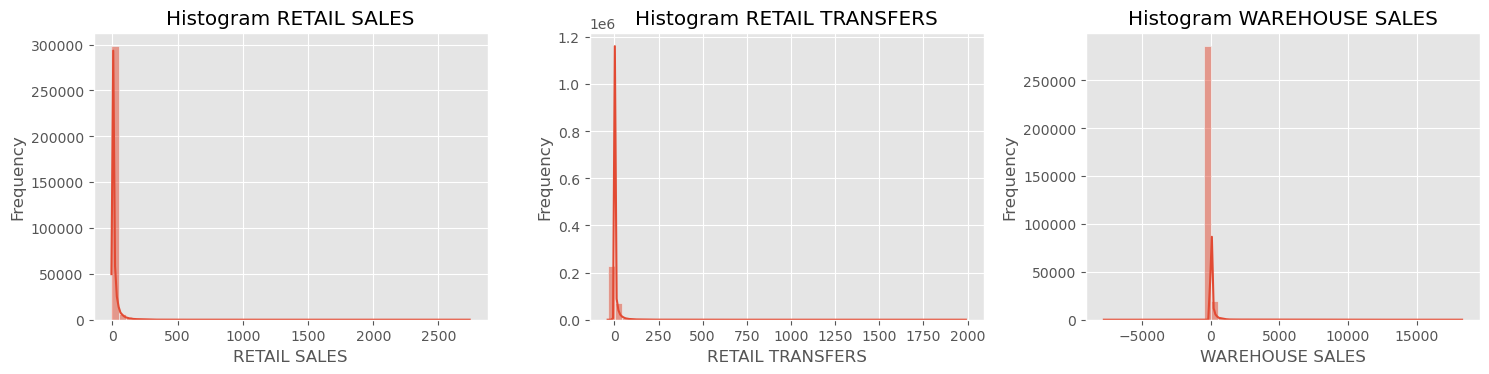

In [366]:

numerical_cols = ['RETAIL SALES', 'RETAIL TRANSFERS', 'WAREHOUSE SALES']

plt.figure(figsize=(15, 4))
for i, col in enumerate(numerical_cols, 1):
    plt.subplot(1, 3, i)
    sns.histplot(df[col], bins=50, kde=True)
    plt.title(f'Histogram {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


Korelasi antar fitur numerik

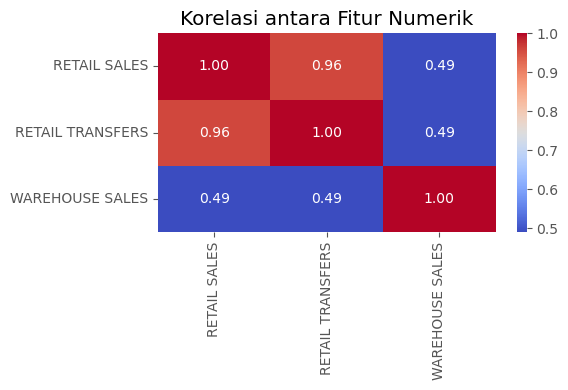

In [367]:

correlation_matrix = df[numerical_cols].corr()

# Visualisasi heatmap korelasi
plt.figure(figsize=(6, 4))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Korelasi antara Fitur Numerik')
plt.tight_layout()
plt.show()


**Interpretasi:**

1. Korelasi antara fitur RETAIL SALES dengan RETAIL TRANSFERS sangat tinggi dengan nilai **0.96**. Hal tersebut mengindikasikan jumlah transfer stok antar toko memiliki kaitan yang kuat dengan penjualan akhir ke konsumen. 

2. Korelasi antara fitur RETAIL SALES dengan WAREHOUSE SALES sedang dengan nilai korelasi **0.49**. Disebabkan karena penjualan dari gudang mendahului penjualan ke konsumen.

3. Korelasi antara fitur RETAIL TRANSFERS dengan WAREHOUSE SALES sedang dengan nilai korelasi yang sama, yakni **0.49**. Ini mencerminkan bahwa ketika warehouse melakukan penjualan tinggi, ada kecenderungan sistem distribusi antar toko juga bergerak aktif.

Check Outlier

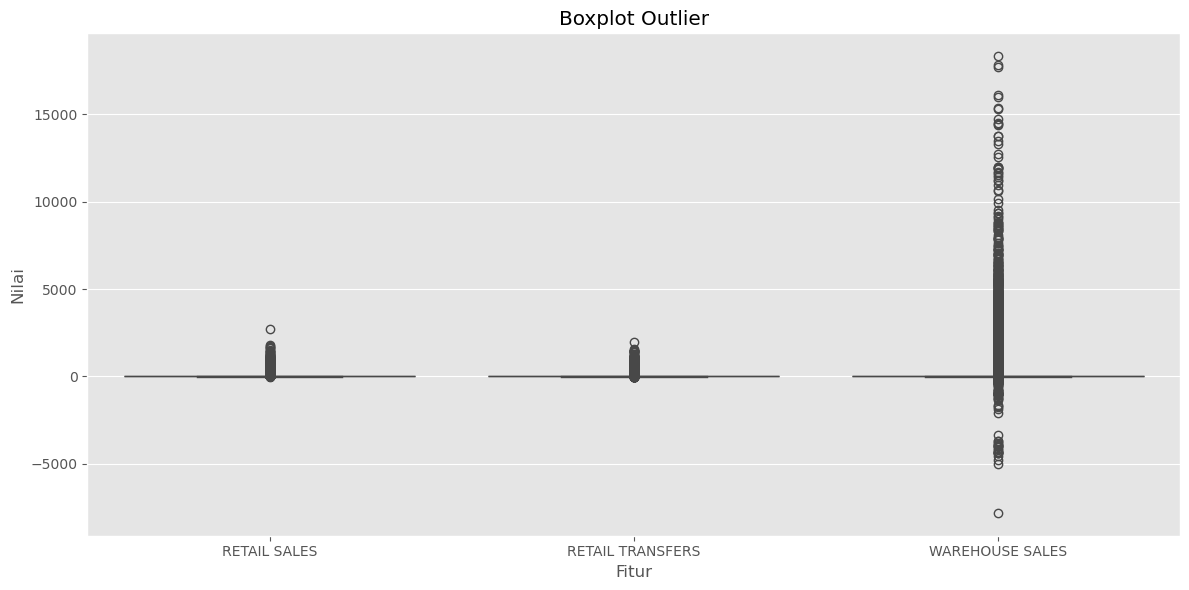

In [368]:
# Visualisasi boxplot untuk deteksi outlier pada fitur numerik
plt.figure(figsize=(12, 6))
sns.boxplot(data=df[numerical_cols])
plt.title('Boxplot Outlier')
plt.ylabel('Nilai')
plt.xlabel('Fitur')
plt.tight_layout()
plt.show()

# **Univariate Analysis**


Top 20: SUPPLIER
REPUBLIC NATIONAL DISTRIBUTING CO        : 20995 sampel (6.8%)
LEGENDS LTD                              : 13634 sampel (4.4%)
SOUTHERN GLAZERS WINE AND SPIRITS        : 11720 sampel (3.8%)
E & J GALLO WINERY                       : 10816 sampel (3.5%)
THE COUNTRY VINTNER, LLC DBA WINEBOW     : 10669 sampel (3.5%)
MONSIEUR TOUTON SELECTION                : 10360 sampel (3.4%)
A VINTNERS SELECTIONS                    :  9994 sampel (3.3%)
BACCHUS IMPORTERS LTD                    :  9150 sampel (3.0%)
DIAGEO NORTH AMERICA INC                 :  7520 sampel (2.4%)
RELIABLE CHURCHILL LLLP                  :  6971 sampel (2.3%)
CONSTELLATION BRANDS                     :  6684 sampel (2.2%)
JIM BEAM BRANDS CO                       :  5993 sampel (1.9%)
ANHEUSER BUSCH INC                       :  5835 sampel (1.9%)
DOPS INC                                 :  5265 sampel (1.7%)
PERNOD RICARD USA LLC                    :  5141 sampel (1.7%)
PRESTIGE BEVERAGE GROUP OF MD LLC    

C:\Users\Randy Sam\AppData\Local\Temp\ipykernel_28456\471662010.py:15: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




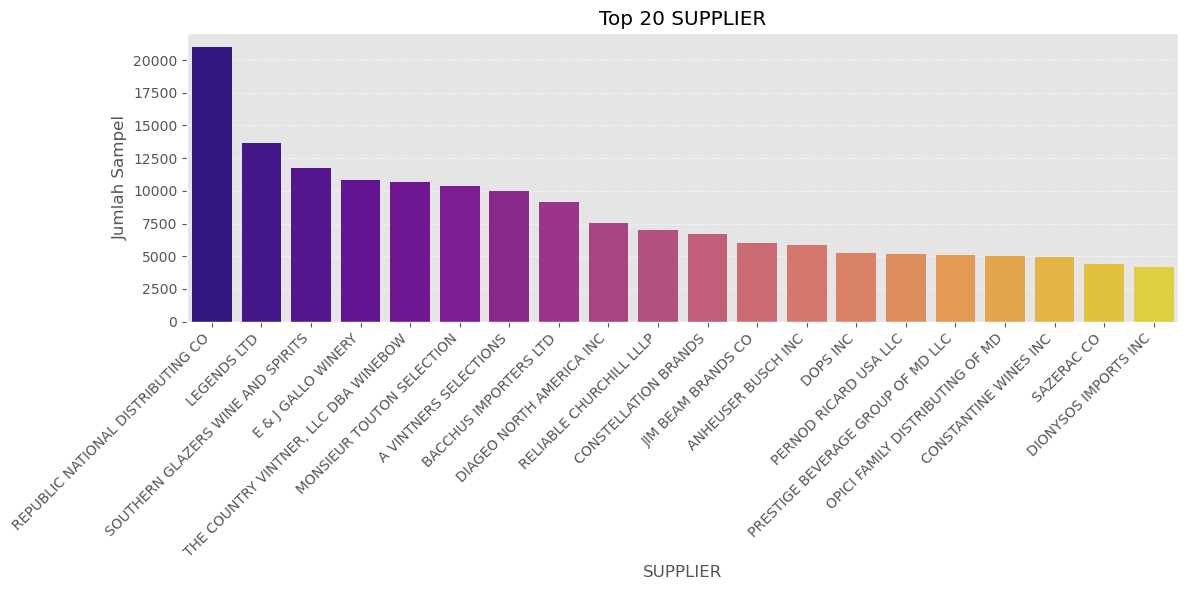

In [ ]:
categorical_cols = ["SUPPLIER", "ITEM TYPE"]
top_n = 20
feature = categorical_cols[0]

count = df[feature].value_counts().head(top_n)
percent = df[feature].value_counts(normalize=True).head(top_n) * 100

print(f"\nTop {top_n}: {feature}")
for idx in count.index:
    print(f"{idx:<40} : {count[idx]:>5} sampel ({percent[idx]:.1f}%)")

count.plot(kind='bar', title=f"Top {top_n} {feature}", figsize=(12, 6))
sns.barplot(x=count.index, y=count.values, palette='plasma')
plt.ylabel("Jumlah Sampel", fontsize=12)
plt.xlabel(feature, fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()


Univariate Analysis: ITEM TYPE
WINE                      : 187640 sampel (61.0%)
LIQUOR                    : 64910 sampel (21.1%)
BEER                      : 42413 sampel (13.8%)
KEGS                      : 10146 sampel (3.3%)
NON-ALCOHOL               :  1908 sampel (0.6%)
STR_SUPPLIES              :   405 sampel (0.1%)
REF                       :   127 sampel (0.0%)
DUNNAGE                   :    95 sampel (0.0%)


C:\Users\Randy Sam\AppData\Local\Temp\ipykernel_28456\4108733311.py:16: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




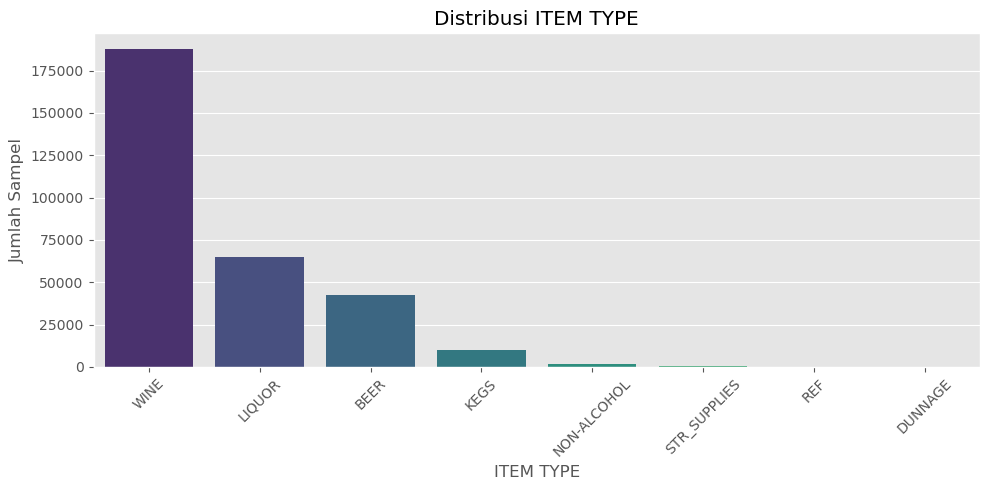

In [ ]:
feature = categorical_cols[1]

count = df[feature].value_counts()
percent = df[feature].value_counts(normalize=True) * 100

print(f"\nUnivariate Analysis: {feature}")
for idx in count.index:
    print(f"{idx:<25} : {count[idx]:>5} sampel ({percent[idx]:.1f}%)")

count.plot(kind='bar', title=f"Distribusi {feature}", figsize=(10, 5))
sns.barplot(x=count.index, y=count.values, palette='viridis')
plt.ylabel("Jumlah Sampel")
plt.xlabel(feature)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

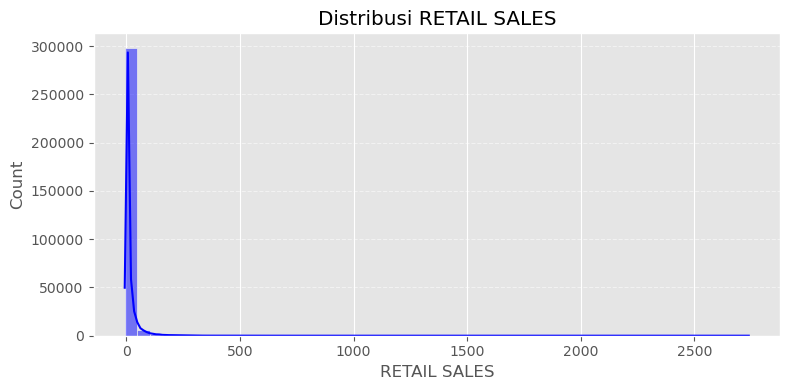

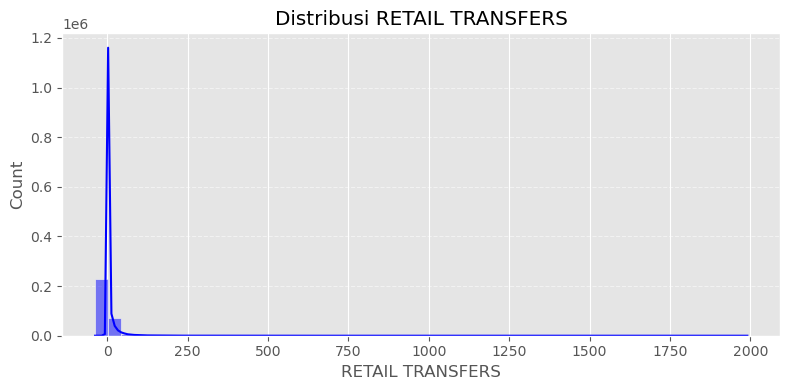

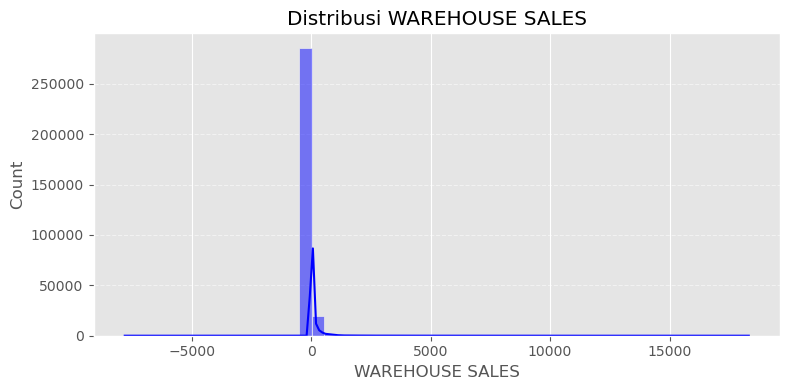

In [371]:
for feature in numerical_cols:
    plt.figure(figsize=(8, 4))
    sns.histplot(df[feature], bins=50, kde=True, color='blue')
    plt.title(f'Distribusi {feature}')
    plt.xlabel(feature)
    plt.ylabel('Count')
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()


**Insights:**

**1. Distribusi Numerik**
- Mayoritas nilai penjualan dan transfer berada di kisaran sangat rendah (dekat nol).
- Distribusi ketiga fitur sangat right-skewed, sebagian kecil transaksi memiliki volume yang sangat besar, menciptakan long tail.
- Sebagian besar transaksi kecil, tapi ada transaksi besar yang signifikan dan perlu dikelola secara khusus (misalnya untuk analisis loyalitas atau pembelian massal).

**2. Distribusi Kategorikal**
- **SUPPLIER:**
    - Dari Top 20 supplier, hanya beberapa yang mendominasi jumlah transaksi yang dapat berarti bahwa distribusi tidak merata.
    - Pasar dikuasai oleh sedikit supplier besar, yang berarti upaya manajemen stok atau prediksi permintaan bisa lebih fokus ke mereka.

- **ITEM TYPE:**
    - Tipe item yang muncul paling banyak adalah seperti 'WINE' dan 'LIQUOR'.

# **Data Binning**

C:\Users\Randy Sam\AppData\Local\Temp\ipykernel_28456\1747431516.py:23: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


C:\Users\Randy Sam\AppData\Local\Temp\ipykernel_28456\1747431516.py:29: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




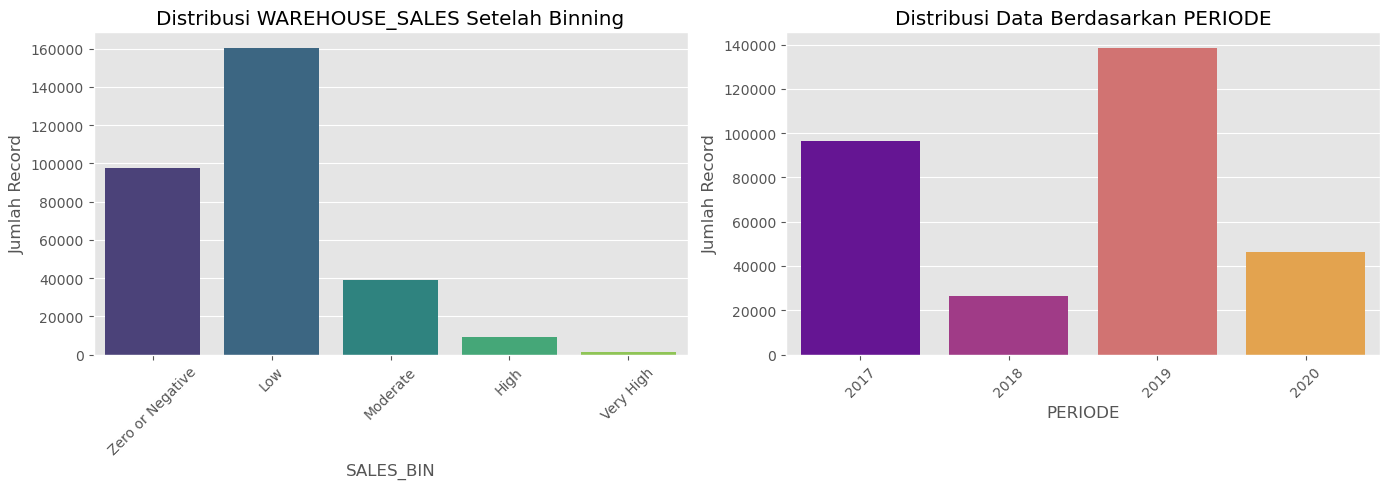

In [ ]:


df['PERIODE'] = pd.cut(df['YEAR'], bins=[2016, 2017, 2018, 2019, 2020],
                           labels=['2017', '2018', '2019', '2020'], right=True)

# Binning WAREHOUSE_SALES into categories
df['SALES_BIN'] = pd.cut(df['WAREHOUSE SALES'],
                              bins=[-float('inf'), 0, 10, 100, 1000, float('inf')],
                              labels=['Zero or Negative', 'Low', 'Moderate', 'High', 'Very High'])

# Show the distribution
sales_bin_distribution = df['SALES_BIN'].value_counts().sort_index()
periode_distribution = df['PERIODE'].value_counts().sort_index()

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.barplot(x=sales_bin_distribution.index, y=sales_bin_distribution.values, ax=axes[0], palette='viridis')
axes[0].set_title('Distribusi WAREHOUSE_SALES Setelah Binning')
axes[0].set_ylabel('Jumlah Record')
axes[0].tick_params(axis='x', rotation=45)

sns.barplot(x=periode_distribution.index, y=periode_distribution.values, ax=axes[1], palette='plasma')
axes[1].set_title('Distribusi Data Berdasarkan PERIODE')
axes[1].set_ylabel('Jumlah Record')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


C:\Users\Randy Sam\AppData\Local\Temp\ipykernel_28456\3201604106.py:11: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




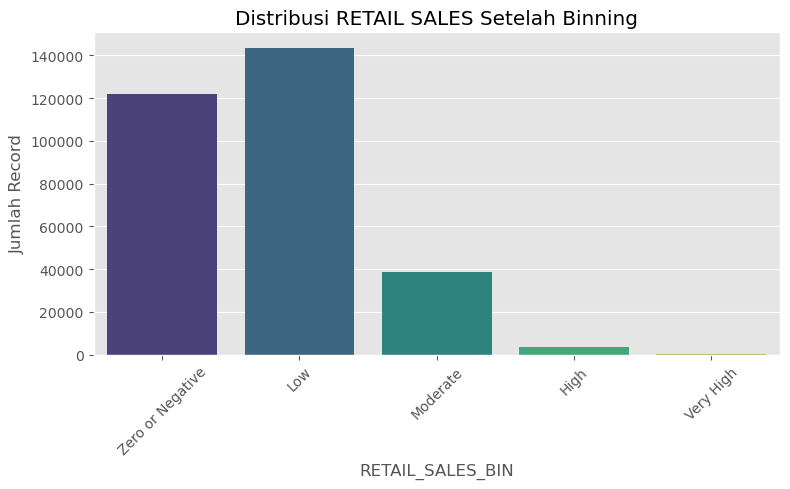

In [ ]:
df['RETAIL_SALES_BIN'] = pd.cut(df['RETAIL SALES'],
                                     bins=[-float('inf'), 0, 10, 100, 1000, float('inf')],
                                     labels=['Zero or Negative', 'Low', 'Moderate', 'High', 'Very High'])

retail_sales_bin_distribution = df['RETAIL_SALES_BIN'].value_counts().sort_index()

plt.figure(figsize=(8, 5))
sns.barplot(x=retail_sales_bin_distribution.index, y=retail_sales_bin_distribution.values, palette='viridis')
plt.title('Distribusi RETAIL SALES Setelah Binning')
plt.ylabel('Jumlah Record')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


**Insights:**

**1. Retail Sales**

Transaksi ritel didominasi oleh volume kecil, bahkan banyak bernilai 0 atau negatif serta hanya sebagian kecil transaksi yang melibatkan penjualan besar. Kemungkinan ini disebabkan karena orang cenderung membeli dalam ukuran yang kecil.

**3. Warehouse Sales**

Aktivitas gudang juga didominasi oleh distribusi dalam jumlah kecil serta volume besar di gudang hanya terjadi dalam kasus khusus atau periode tertentu.

**3. Periode (Tahun)**

Tahun 2019 bisa menjadi tahun penyumbang jumlah transaksi besar.

# **Data Cleaning**

Mengatasi missing values kolom kategorik dengan Modus

In [374]:
categorical_cols = ["SUPPLIER", "ITEM TYPE"]
for col in categorical_cols:
    mode = df[col].mode()[0]
    df[col] = df[col].fillna(mode)

Mengatasi missing values kolom numerik dengan metode Drop

In [375]:
df = df.dropna(subset=['RETAIL SALES'])

In [376]:
df.isnull().sum()

YEAR                0
MONTH               0
SUPPLIER            0
ITEM CODE           0
ITEM DESCRIPTION    0
ITEM TYPE           0
RETAIL SALES        0
RETAIL TRANSFERS    0
WAREHOUSE SALES     0
PERIODE             0
SALES_BIN           0
RETAIL_SALES_BIN    0
dtype: int64

In [377]:
df.head()

,YEAR,MONTH,SUPPLIER,ITEM CODE,ITEM DESCRIPTION,ITEM TYPE,RETAIL SALES,RETAIL TRANSFERS,WAREHOUSE SALES,PERIODE,SALES_BIN,RETAIL_SALES_BIN
0,2020,1,REPUBLIC NATIONAL DISTRIBUTING CO,100009,BOOTLEG RED - 750ML,WINE,0.00,0.0,2.0,2020,Low,Zero or Negative
1,2020,1,PWSWN INC,100024,MOMENT DE PLAISIR - 750ML,WINE,0.00,1.0,4.0,2020,Low,Zero or Negative
2,2020,1,RELIABLE CHURCHILL LLLP,1001,S SMITH ORGANIC PEAR CIDER - 18.7OZ,BEER,0.00,0.0,1.0,2020,Low,Zero or Negative
3,2020,1,LANTERNA DISTRIBUTORS INC,100145,SCHLINK HAUS KABINETT - 750ML,WINE,0.00,0.0,1.0,2020,Low,Zero or Negative
4,2020,1,DIONYSOS IMPORTS INC,100293,SANTORINI GAVALA WHITE - 750ML,WINE,0.82,0.0,0.0,2020,Zero or Negative,Low


In [378]:
for col in numerical_cols:
    # Winsorize dengan 5% trimming di kedua sisi (bawah dan atas)
    df[col] = winsorize(df[col], limits=[0.05, 0.05])

C:\Users\Randy Sam\AppData\Local\Temp\ipykernel_28456\3500522981.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



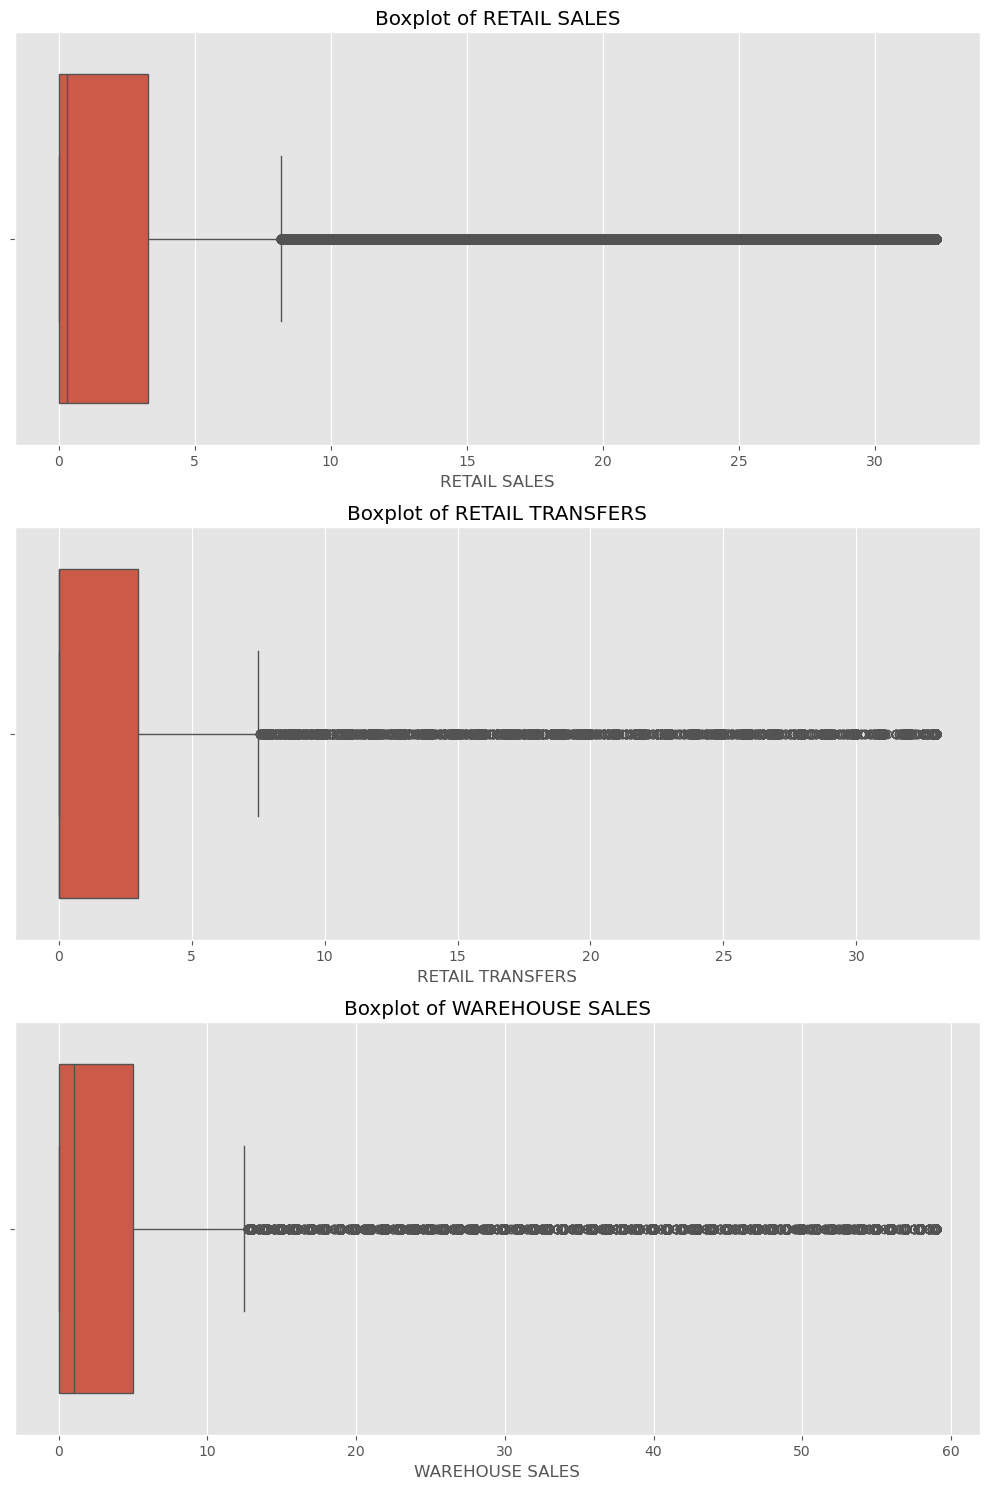

In [379]:
fig, axes = plt.subplots(len(numerical_cols), 1,  figsize=(10, 5 * len(numerical_cols)))
for i, col in enumerate(numerical_cols):
    sns.boxplot(x=df[col], ax=axes[i])
    axes[i].set_title(f'Boxplot of {col}')
plt.tight_layout()
plt.show()

In [380]:
scaler = MinMaxScaler()
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

C:\Users\Randy Sam\AppData\Local\Temp\ipykernel_28456\1455986141.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



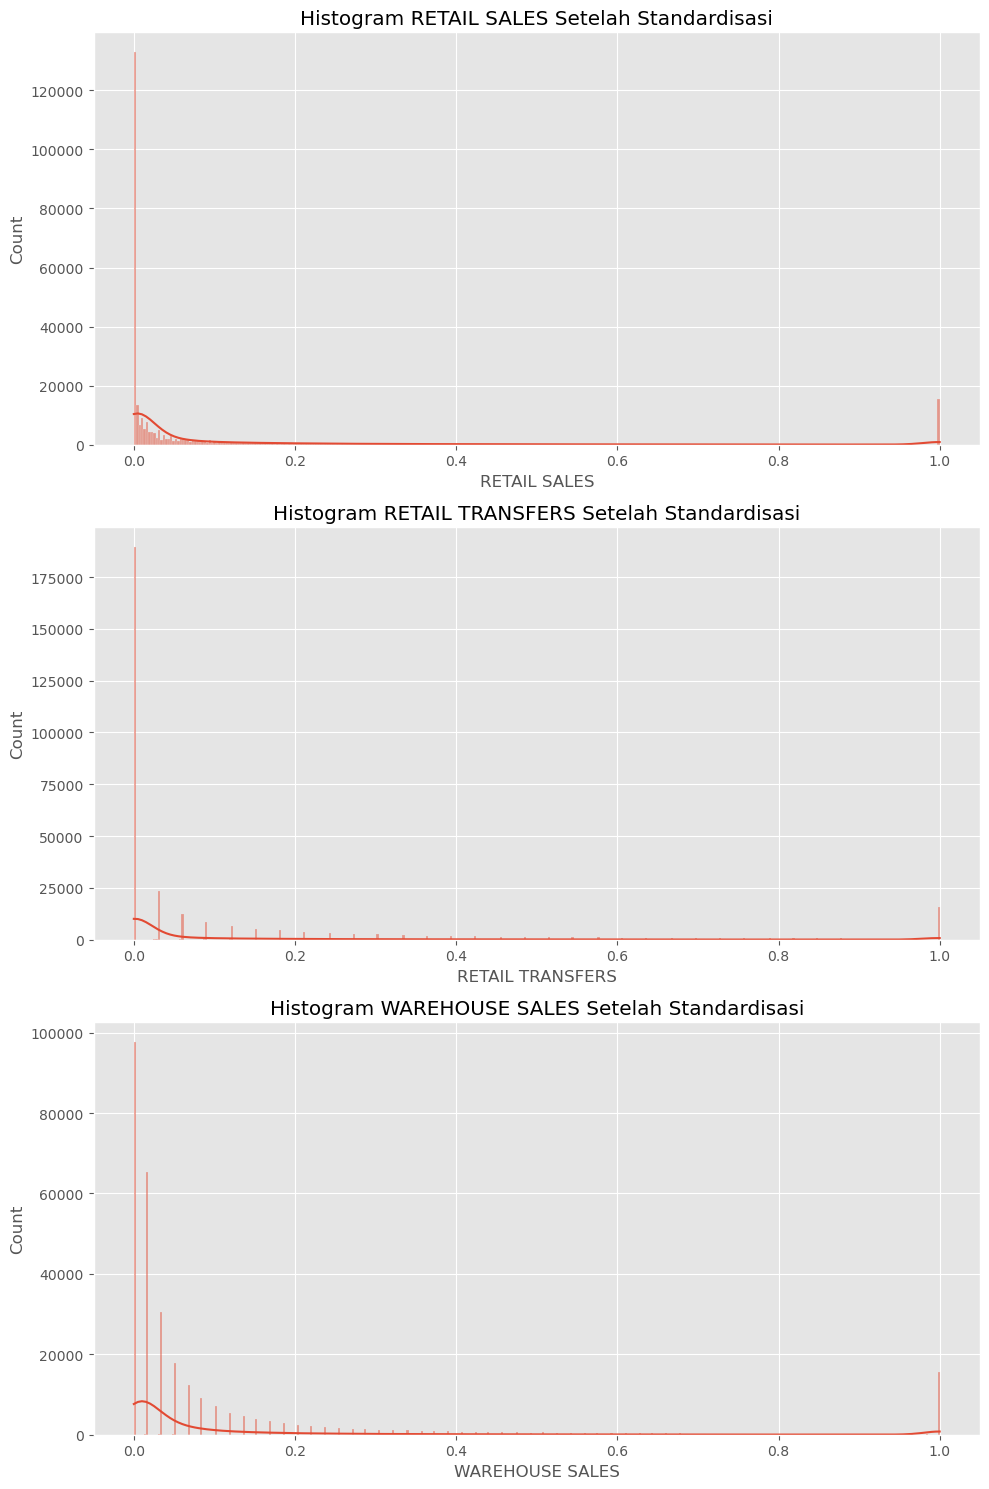

In [381]:
# Histogram: Standardisasi
fig, axes = plt.subplots(len(numerical_cols), 1, figsize=(10, 5 * len(numerical_cols)))
for i, col in enumerate(numerical_cols):
    sns.histplot(df[col], kde=True, ax=axes[i])
    axes[i].set_title(f'Histogram {col} Setelah Standardisasi')
plt.tight_layout()
plt.show()

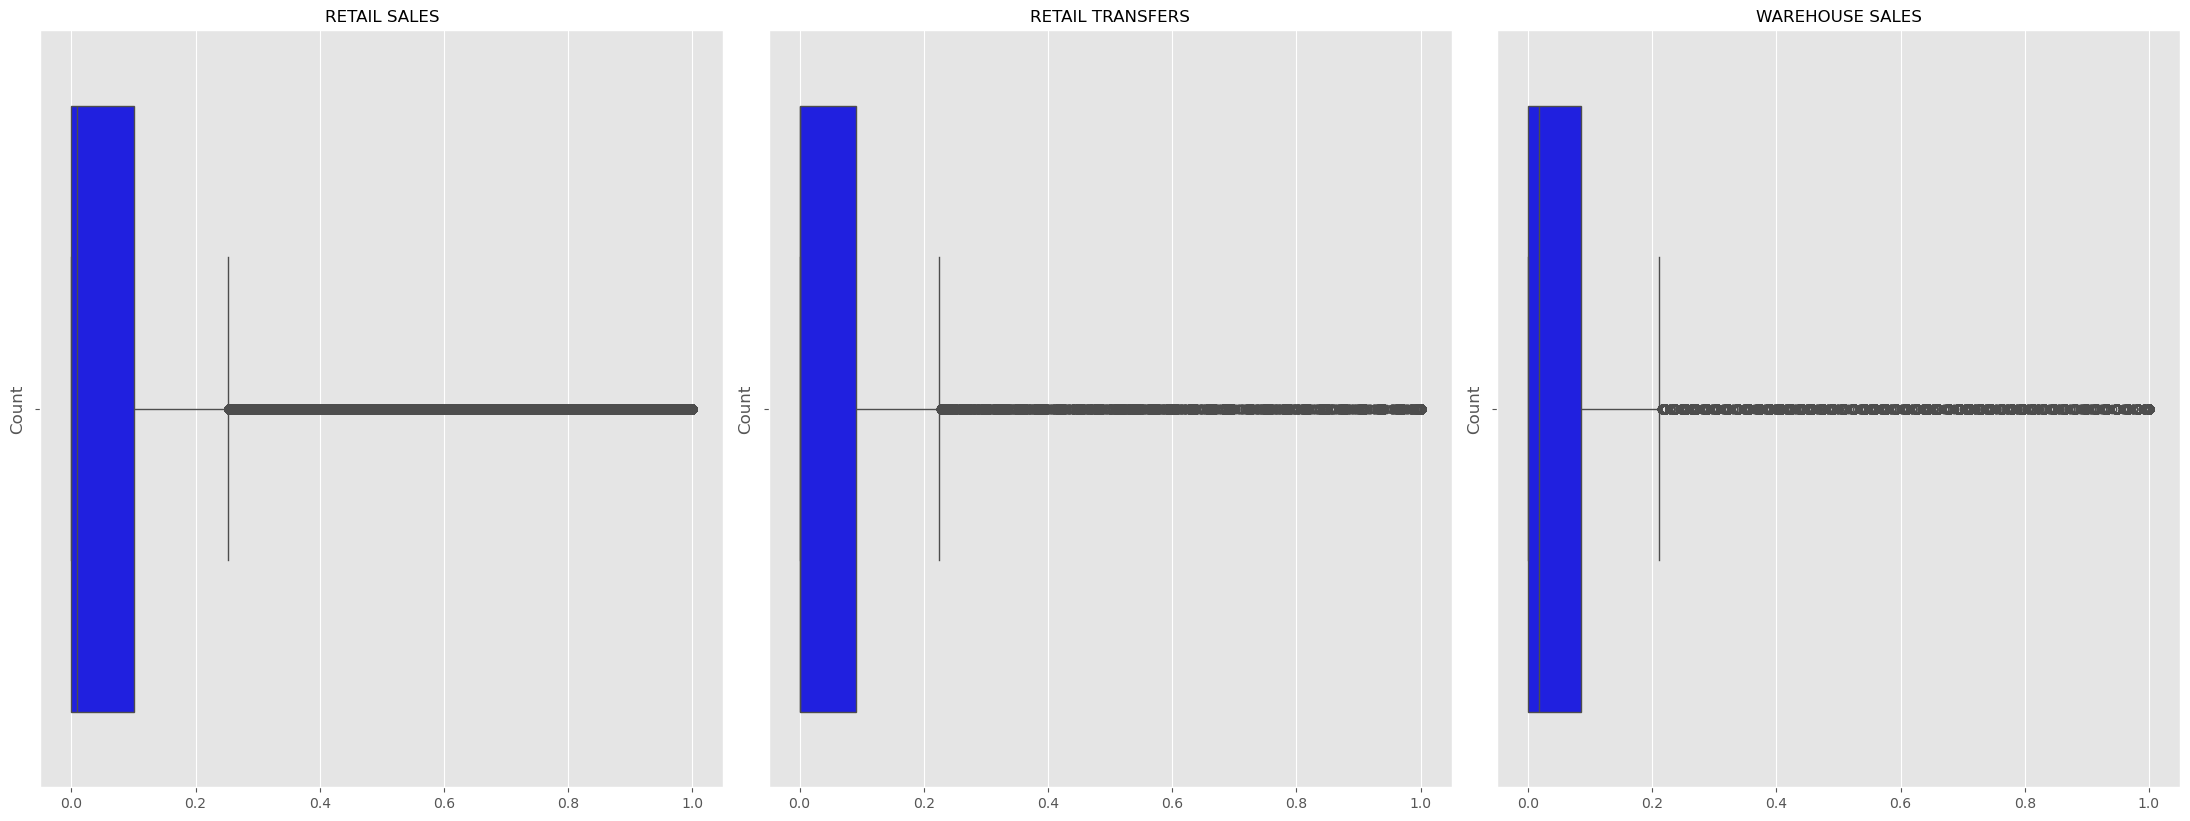

In [382]:
plt.figure(figsize=(22,24))
plt.style.use('ggplot')

for i, col in enumerate(numerical_cols):
    plt.subplot(3, 3, i + 1)
    sns.boxplot(data=df, x=col, color='blue')
    plt.title(f'{col}', fontsize=12)
    plt.xlabel('')
    plt.ylabel('Count')

plt.tight_layout()
plt.show()

**Insights:**

Outlier yang masih muncul setelah preprocessing tidak selalu menunjukkan kesalahan. Dalam banyak kasus, hal tersebut justru mencerminkan karakteristik alami dari data, terutama pada domain penjualan di mana jumlah transaksi kecil sangat dominan. Teknik seperti winsorizing dan MinMaxScaler membantu mengontrol dampak outlier, tapi tidak menghilangkannya sepenuhnya dan itu memang normal serta bisa diterima.

In [391]:
Q1 = df['RETAIL SALES'].quantile(0.25)
Q3 = df['RETAIL SALES'].quantile(0.75)
IQR = Q3 - Q1
lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR

df_outliers = df[(df['RETAIL SALES'] < lower) | (df['RETAIL SALES'] > upper)]
print("Jumlah Outlier:", len(df_outliers))


Jumlah Outlier: 48013


# **Modelling**

In [402]:
# Select features and target variable
predictor_features = ['RETAIL TRANSFERS', 'WAREHOUSE SALES']
target = 'RETAIL SALES'

X = df[predictor_features]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

rfr_mae = mean_absolute_error(y_test, y_pred)
rfr_mse = mean_squared_error(y_test, y_pred)
rfr_r2 = r2_score(y_test, y_pred)
rfr_rmse = math.sqrt(mean_squared_error(y_test, y_pred))
rfr_cv_scores = cross_val_score(model, X, y, cv=5, scoring='r2')

print(f'Random Forest Regressor MAE: {rfr_mae:.4f}')
print(f"Random Forest Regressor MSE: {rfr_mse}")
print(f'Random Forest Regressor R2 Score: {rfr_r2:.4f}')
print(f"Random Forest Regressor RMSE: {rfr_rmse:.4f}")
print(f'Cross-validated R2 scores: {rfr_cv_scores}')
print(f'Mean CV R2 score: {rfr_cv_scores.mean():.4f}')

Random Forest Regressor MAE: 0.0340
Random Forest Regressor MSE: 0.005923961162636742
Random Forest Regressor R2 Score: 0.9128
Random Forest Regressor RMSE: 0.0770
Cross-validated R2 scores: [0.91481185 0.90741833 0.89901608 0.94072591 0.90738858]
Mean CV R2 score: 0.9139


In [403]:
LR = LinearRegression().fit(X_train, y_train)
 
pred_LR = LR.predict(X_test)
 
mae_LR = mean_absolute_error(y_test, pred_LR)
mse_LR = mean_squared_error(y_test, pred_LR)
r2_LR = r2_score(y_test, pred_LR)
lr_rmse = math.sqrt(mean_squared_error(y_test, pred_LR))
lr_cv_scores = cross_val_score(LR, X, y, cv=5, scoring='r2')
 
print(f"Linear Regression MAE: {mae_LR}")
print(f"Linear Regression MSE: {mse_LR}")
print(f"Linear Regression R²: {r2_LR}")
print(f"Linear Regression RMSE: {lr_rmse:.4f}")
print(f'Cross-validated R2 scores: {lr_cv_scores}')
print(f'Mean CV R2 score: {lr_cv_scores.mean():.4f}')

Linear Regression MAE: 0.03555114120422481
Linear Regression MSE: 0.005875468635220463
Linear Regression R²: 0.9135400961705983
Linear Regression RMSE: 0.0767
Cross-validated R2 scores: [0.91687132 0.90757873 0.89887045 0.94317904 0.9067603 ]
Mean CV R2 score: 0.9147


In [404]:
GBR = GradientBoostingRegressor(random_state=184)
GBR.fit(X_train, y_train)
 
pred_GBR = GBR.predict(X_test)
 
mae_GBR = mean_absolute_error(y_test, pred_GBR)
mse_GBR = mean_squared_error(y_test, pred_GBR)
r2_GBR = r2_score(y_test, pred_GBR)
gbr_rmse = math.sqrt(mean_squared_error(y_test, pred_GBR))
gbr_cv_scores = cross_val_score(GBR, X, y, cv=5, scoring='r2')
 
print(f"Gradient Boosting Regressor MAE: {mae_GBR}")
print(f"Gradient Boosting Regressor MSE: {mse_GBR}")
print(f"Gradient Boosting Regressor R²: {r2_GBR}")
print(f"Gradient Boosting Regressor RMSE: {gbr_rmse:.4f}")
print(f'Cross-validated R2 scores: {gbr_cv_scores}')
print(f'Mean CV R2 score: {gbr_cv_scores.mean():.4f}')

Gradient Boosting Regressor MAE: 0.03343745169046668
Gradient Boosting Regressor MSE: 0.005694123556158939
Gradient Boosting Regressor R²: 0.9162086625555171
Gradient Boosting Regressor RMSE: 0.0755
Cross-validated R2 scores: [0.91885221 0.91136005 0.90252728 0.94403925 0.91023117]
Mean CV R2 score: 0.9174


In [406]:

evaluation_metrics = pd.DataFrame({
    'Model': ['Random Forest Regressor', 'Linear Regression', 'Gradient Boosting Regressor'],
    'MAE Score': [rfr_mae, mae_LR, mae_GBR],
    'MSE Score': [rfr_mse, mse_LR, mse_GBR],
    'R2 Score': [rfr_r2, r2_LR, r2_GBR],
    'RMSE': [rfr_rmse, lr_rmse, gbr_rmse],
    'Mean CV R2 Score': [rfr_cv_scores.mean(), lr_cv_scores.mean(), gbr_cv_scores.mean()]
})
evaluation_metrics

,Model,MAE Score,MSE Score,R2 Score,RMSE,Mean CV R2 Score
0,Random Forest Regressor,0.034014,0.005924,0.912827,0.076967,0.913872
1,Linear Regression,0.035551,0.005875,0.913540,0.076652,0.914652
2,Gradient Boosting Regressor,0.033437,0.005694,0.916209,0.075459,0.917402


**Kesimpulan**

Dari percobaan algoritma yang sudah dilakukan, Gradient Boosting Regressor adalah model yang menghasilkan performa terbaik di antara yang lainnya dengan skor R2 mencapai **0.9162** serta skor RMSE terendah dengan **0.0754**. Model lain seperti Random Forest Regressor dan Linear Regression memiliki performa yang baik juga namun tidak sebaik dengan Gradient Boosting Regressor.